In [4]:
import pickle as pkl
import numpy as np
import pandas as pd 


with open('/content/drive/MyDrive/Dataset_with_memory /1min/X_train.pickle', 'rb') as f:
    X_train = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /1min/Y_train.pickle', 'rb') as f:
    Y_train = pkl.load(f)


with open('/content/drive/MyDrive/Dataset_with_memory /1min/Y_val.pickle', 'rb') as f:
    Y_val = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /1min/X_val.pickle', 'rb') as f:
     X_val = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /1min/Y_test.pickle', 'rb') as f:
    Y_test = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /1min/X_test.pickle', 'rb') as f:
     X_test = pkl.load(f)


Y_train = Y_train.reshape((-1,1))
Y_val = Y_val.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

X_train.shape , Y_train.shape , X_val.shape , Y_val.shape , X_test.shape , Y_test.shape

((225480, 120, 5),
 (225480, 1),
 (45000, 120, 5),
 (45000, 1),
 (135240, 120, 5),
 (135240, 1))

In [5]:
from sklearn.utils.class_weight import compute_class_weight



class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique ( np.reshape( Y_train , (np.shape(Y_train)[0]))),
                                        y = np.reshape(Y_train ,(np.shape(Y_train)[0]))                                                 
                                    )
class_weights = dict(zip(np.unique(np.reshape(Y_train ,(np.shape(Y_train)[0]))), class_weights))
class_weights


{0: 1.173189589685422, 1: 0.8713664082607452}

In [ ]:
import os

filepath = "/content/drive/MyDrive/parameter_tuning_GRU.csv"

# check if the file exists, create it if not
if not os.path.isfile(filepath):
    columns_name = ['GRU_blocks', 'learning_rate', 'regularizer', 'droput', 'optimizer', 'batch size' , 'weight_decay',
                    'train_loss' , 'val_loss' , 'train_accuracy' , 'val_accuracy', 'test_loss' , 'test_accuracy']
    df = pd.DataFrame(columns=columns_name)  # create an empty dataframe
    df.to_csv(filepath, index=False)  # save as a CSV file with no index


In [24]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow import keras
import numpy as np 

#reproducibility 
np.random.seed(0)
tf.random.set_seed(0)

#defining hyperparameters

weight_decay = 1e-7
GRU_blocks= 20
regularizer = 0.7
lr = 0.00005
dropout  = 0.5
batchsize = 1000
optimizer_func = 'Adam'
#threshold = 0.5

# Define the model
def create_model(GRU_blocks, regularizer, dropout):
    model = Sequential()
    #model.add(BatchNormalization(input_shape=(120, 5)))
    model.add(GRU(GRU_blocks, input_shape=(120, 5) , return_sequences=False, activation='sigmoid', bias_regularizer=regularizers.l1(regularizer),  kernel_regularizer=regularizers.l1(regularizer)))
   

    model.add(Dropout(dropout))

    #model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    return model 


model = create_model(GRU_blocks, regularizer, dropout)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 20)                1620      
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=lr,weight_decay=weight_decay) if optimizer_func == 'Adam' else keras.optimizers.SGD(learning_rate=lr ,weight_decay=weight_decay)

model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['binary_accuracy' ])


checkpoint_path = '/content/drive/MyDrive/my_best_model_GRU.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')


earlystopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

callback = [earlystopping, checkpoint]
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val , Y_val) , verbose=1,  batch_size=batchsize, epochs=300,callbacks = callback, class_weight=class_weights)

loss, accuracy = model.evaluate(X_test, Y_test, batch_size=batchsize)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

filepath = "/content/drive/MyDrive/parameter_tuning_GRU.csv"
parameters_to_save = pd.read_csv(filepath)

parameters_to_save = parameters_to_save.append({'GRU_blocks' : GRU_blocks, 'learning_rate': lr, 'regularizer': regularizer, 'droput': dropout, 
                                                'optimizer': optimizer_func, 'batch size': batchsize, 'weight_decay': weight_decay,
                                                'train_loss' : history.history['loss'][-1] ,'val_loss' : history.history['val_loss'][-1] , 
                                                'train_accuracy' : history.history['binary_accuracy'][-1] , 'val_accuracy' : history.history['val_binary_accuracy'][-1],
                                                'test_loss' : f"{loss:.4f}" , 'test_accuracy' : f"{accuracy*100:.2f}%" } , ignore_index = True ) 

parameters_to_save.to_csv(filepath, index=False)


Epoch 1/300
226/226 [==============================] - ETA: 0s - loss: 32.1241 - binary_accuracy: 0.4791
Epoch 1: val_binary_accuracy improved from -inf to 0.50644, saving model to /content/drive/MyDrive/my_best_model_GRU.hdf5
226/226 [==============================] - 56s 238ms/step - loss: 32.1241 - binary_accuracy: 0.4791 - val_loss: 30.9102 - val_binary_accuracy: 0.5064
Epoch 2/300
226/226 [==============================] - ETA: 0s - loss: 29.8594 - binary_accuracy: 0.4875
Epoch 2: val_binary_accuracy improved from 0.50644 to 0.50660, saving model to /content/drive/MyDrive/my_best_model_GRU.hdf5
226/226 [==============================] - 57s 250ms/step - loss: 29.8594 - binary_accuracy: 0.4875 - val_loss: 28.7049 - val_binary_accuracy: 0.5066
Epoch 3/300
226/226 [==============================] - ETA: 0s - loss: 27.7063 - binary_accuracy: 0.4909
Epoch 3: val_binary_accuracy improved from 0.50660 to 0.50682, saving model to /content/drive/MyDrive/my_best_model_GRU.hdf5
226/226 [====

<ipython-input-25-8a435ee30931>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_to_save = parameters_to_save.append({'GRU_blocks' : GRU_blocks, 'learning_rate': lr, 'regularizer': regularizer, 'droput': dropout,


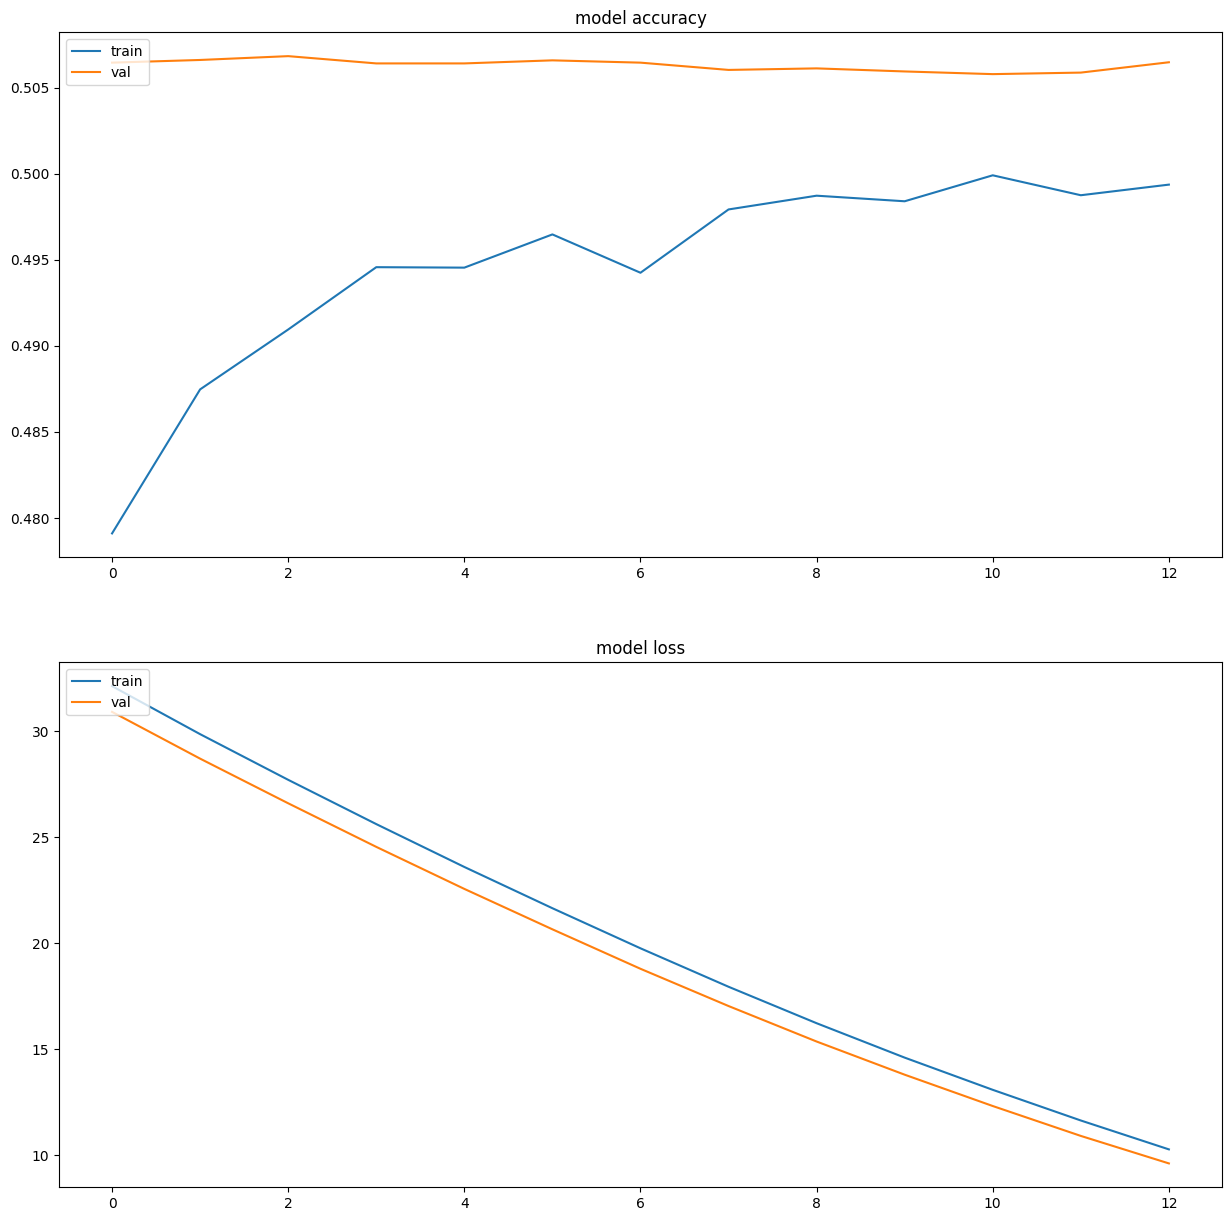

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1, figsize = (15,15))
axs = axs.flatten()
axs[0].plot(history.history['binary_accuracy'])
axs[0].plot(history.history['val_binary_accuracy'])
axs[0].set_title('model accuracy')

axs[0].legend(['train', 'val'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

axs[1].legend(['train', 'val'], loc='upper left')


(5, 60)


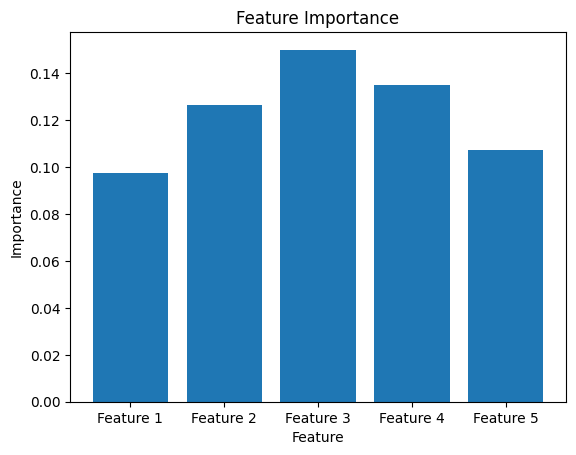

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a trained model called `model`
weights = model.layers[0].get_weights()[0]
print(weights.shape)
importance = np.abs(weights).mean(axis=1)

# Plot feature importance as a bar chart
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), ["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()


Are train accuracy and val accuaracy constant simultaneously ?

